1. Introduction
===============

2. Plotting
=====

2.1 Matplotlib
----------------
- Object-oriented paradigm,

2.2 Seaborn
-------------
 - Side effect of importing it.
 - Examples.

Pandas turns Python into a competitor to R. It allows you to do a wide-scale of statistical operations, but even more importantly, it makes low-level data processing chores easy. For instance, we can load the Iris data set given in CSV format in one single line. This CSV reader is actually much better than you would write with two weeks of effort.

In [2]:
from __future__ import print_function, division
import pandas as pd
iris = pd.read_csv('Iris.csv', index_col=0)
iris.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa


We will use seaborn for some basic visualization

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

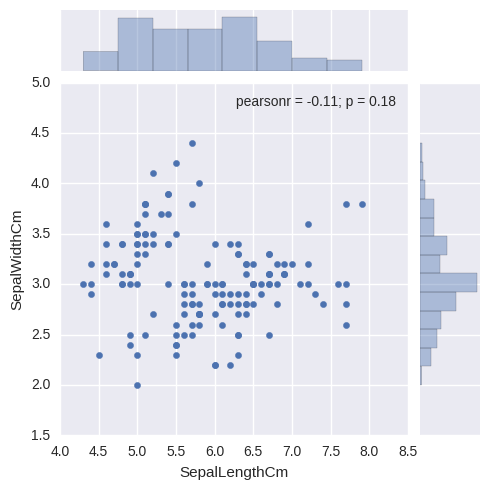

In [31]:
sns.jointplot(x="SepalLengthCm", y="SepalWidthCm", data=iris, size=5)

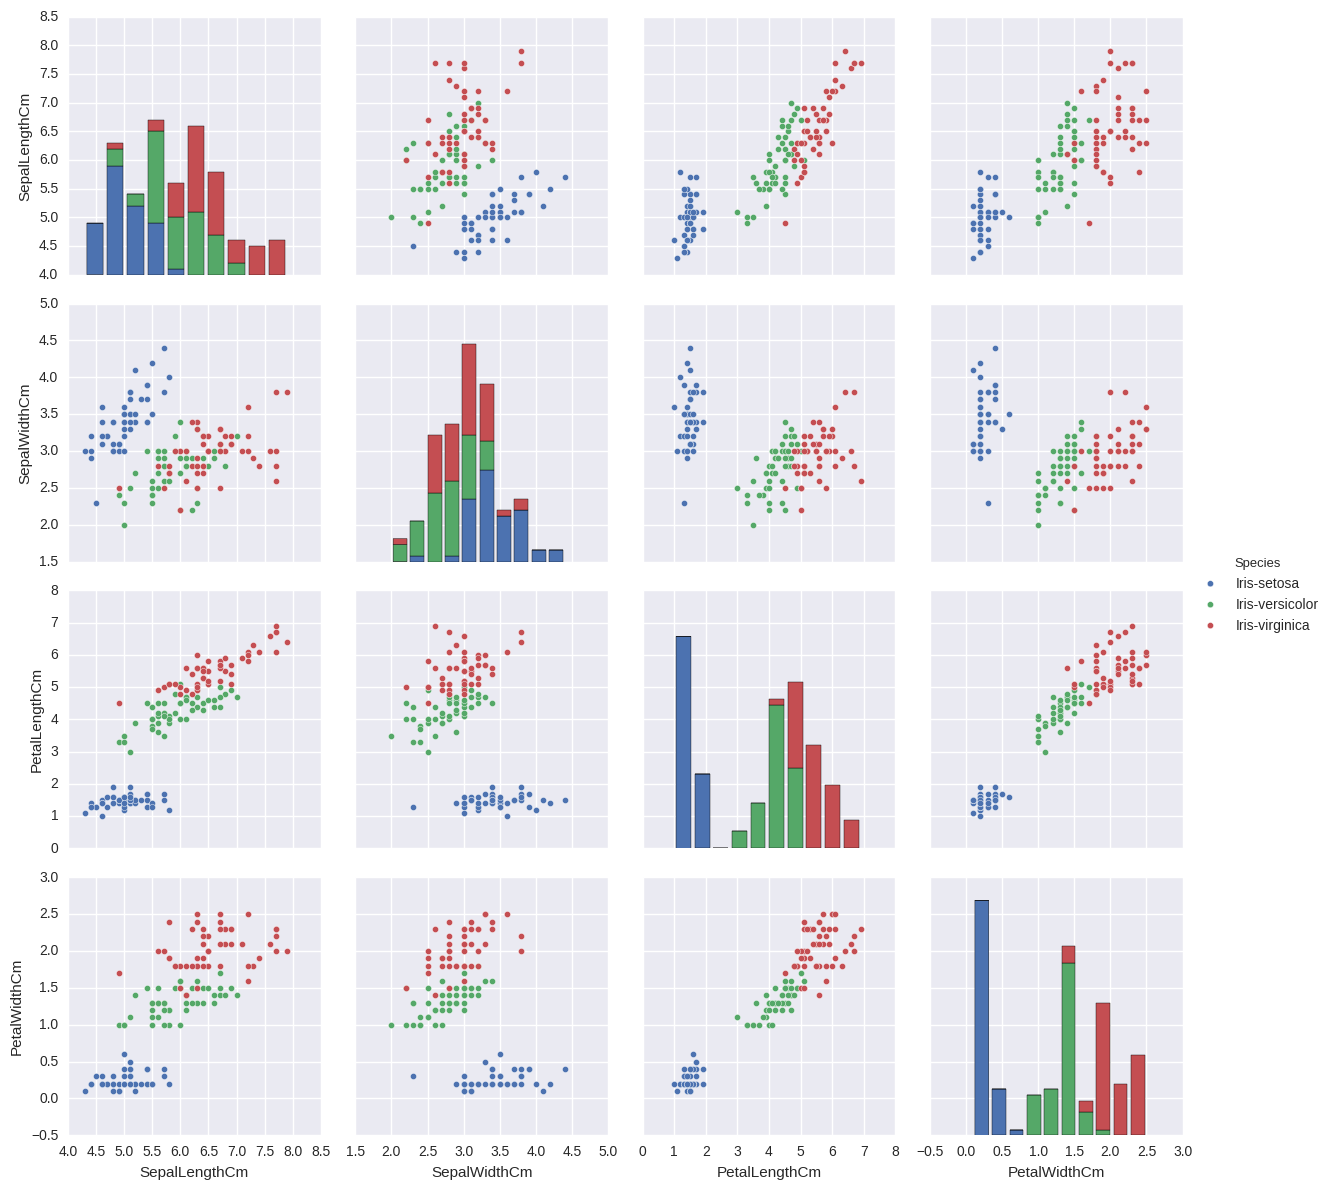

In [33]:
sns.pairplot(iris, hue="Species", size=3)

3. Modelling
============

3.1 Machine learning prototypes
------------------------------------
This section is based on the [examples](https://github.com/rasbt/python-machine-learning-book) in the book [Python Machine Learning](https://www.packtpub.com/big-data-and-business-intelligence/python-machine-learning). 

At the end of the day, most machine learning algorithms will output a function that we can use for any data instance. To characterize the learning algorithm, we can plot the decision boundaries that this function produces. The following helper function plots this decision function along the first two dimensions in the data set:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    alpha=1.0,
                    linewidths=1,
                    marker='o',
                    s=55, label='test set')

We reload the Iris data set. In principle, we could convert the Pandas data frame from the previous section, but this data set is actually integrated in Scikit-learn, so we just load that:

In [2]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target
print('Class labels:', np.unique(y))

Class labels: [0 1 2]


To avoid overfitting, we split the data set in a training and validation part. This is a static random split, not something you would use in 10x random cross-validation.

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

We standardize the distribution of the features of the data set. Some kind of normalization or standardization is usually a good idea. Certain learning models work well with data vectors of norm 1, for instance. Here we choose standardization because the physical size parameters of the iris species actually follows a normal distribution.

In [6]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

The dumbest model we can possibly train is a neural network of a single neuron, trained by stochastic gradient descent. Even this simple model misses only four instances:

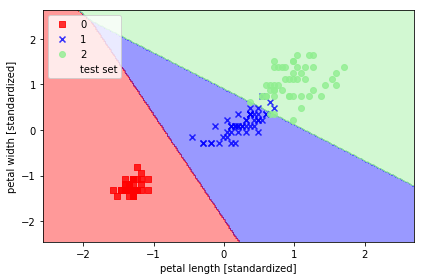

In [7]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=1000.0, random_state=0)
lr.fit(X_train_std, y_train)

plot_decision_regions(X_combined_std, y_combined,
                      classifier=lr, test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

The decision boundary is linear. 

Notice the `C` parameter in the instantiation of the logistic regression class. This is not a parameter, but a hyperparameter: the training algorithm (the same stochastic gradient descent as in the perceptron) does not optimize over it. It is our task to find a good value for it. The objective function we are optimizing for logistic regression is

$$J(\mathbf{w}) = \sum_{i=1}^N\left[-y_i \log(\phi(z_i))-(1-y_i)\log(1-\phi(z_i))\right] + \frac{1}{2C}||w||^2$$,

where $z = w^\top x$. By increasing the regularization term $\frac{1}{2C}$, we get a sparser model. In our case, it means that fewer features will be factored in. We can plot this as follows:

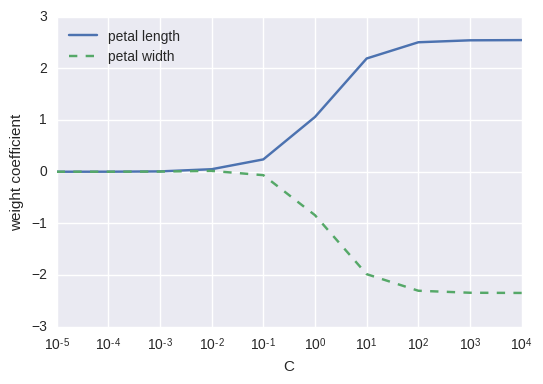

In [21]:
weights, params = [], []
for c in np.arange(-5, 5):
    lr = LogisticRegression(C=10**c, random_state=0)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)

weights = np.array(weights)
plt.plot(params, weights[:, 0],
         label='petal length')
plt.plot(params, weights[:, 1], linestyle='--',
         label='petal width')
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
plt.show()

This regularization term makes machine learning very different from statistics, at least as far as structural risk minimization goes. In general, sparser model will have better generalization properties, that is, they are less prone to overfitting. Since there is no explicit way to optimize over the hyperparameter, you typically do something like grid search.

3.2 Quantum simulations
---------------------------

First we import a handful of functions from QuTiP:

In [12]:
from __future__ import print_function, division
import numpy as np
import pylab as plt
from qutip import destroy, basis, steadystate, expect, mcsolve, mesolve, \
    thermal_dm, plot_fock_distribution, matrix_histogram, hinton, tensor
%matplotlib inline

We take an example from the QuTiP documentation (Section 3.6.5). It is a system that reaches a steady state is a harmonic oscillator coupled to a thermal environment. The initial state is the $|10\rangle$ number state, and it is weakly coupled to a thermal environment characterized by an average particle expectation value of $\langle n\rangle = 2$.

In [13]:
N = 20
a = destroy(N)
H = a.dag() * a
psi0 = basis(N, 10) # initial state
kappa = 0.1 # coupling to oscillator

Next we define the collapse operators:

In [14]:
n_th_a = 2 # temperature with average of 2 excitations
rate = kappa * (1 + n_th_a)
c_op_list = [np.sqrt(rate) * a] # decay operators
rate = kappa * n_th_a
c_op_list.append(np.sqrt(rate) * a.dag()) # excitation operators

We calculate the steady state and the particle number in the steady state:

In [15]:
final_state = steadystate(H, c_op_list)
fexpt = expect(a.dag() * a, final_state)

We calculate the time evolution over a hundred points with two methods: by the Monte Carlo method and by solving the master equation:

In [16]:
tlist = np.linspace(0, 50, 100)
# monte-carlo
mcdata = mcsolve(H, psi0, tlist, c_op_list, [a.dag() * a], ntraj=100)
# master eq.
medata = mesolve(H, psi0, tlist, c_op_list, [a.dag() * a])

10.0%. Run time:   0.45s. Est. time left: 00:00:00:04
20.0%. Run time:   0.81s. Est. time left: 00:00:00:03
30.0%. Run time:   1.13s. Est. time left: 00:00:00:02
40.0%. Run time:   1.49s. Est. time left: 00:00:00:02
50.0%. Run time:   1.86s. Est. time left: 00:00:00:01
60.0%. Run time:   2.20s. Est. time left: 00:00:00:01
70.0%. Run time:   2.52s. Est. time left: 00:00:00:01
80.0%. Run time:   2.84s. Est. time left: 00:00:00:00
90.0%. Run time:   3.10s. Est. time left: 00:00:00:00
100.0%. Run time:   3.47s. Est. time left: 00:00:00:00
Total run time:   3.53s


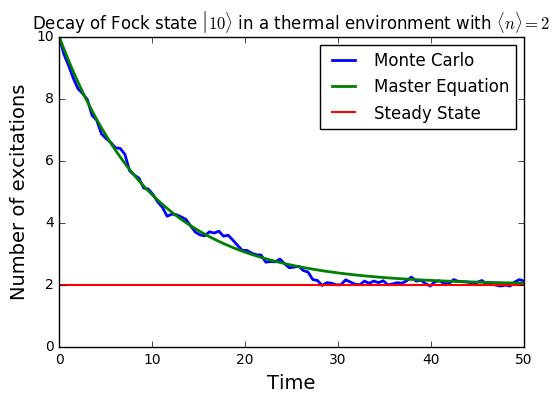

In [17]:
plt.plot(tlist, mcdata.expect[0], tlist, medata.expect[0], lw=2)
plt.axhline(y=fexpt, color='r', lw=1.5)
plt.ylim([0, 10])
plt.xlabel('Time', fontsize=14)
plt.ylabel('Number of excitations', fontsize=14)
plt.legend(('Monte Carlo', 'Master Equation', 'Steady State'))
plt.title('Decay of Fock state $\left|10\\rangle\\right.$' + ' in a thermal environment with $\langle n\\rangle=2$')


**Exercise 3.1** Improve the Monte Carlo simulation to approximate the master equation closer. Typing `mcsolve?` will give you a detailed help on the parametrization of the solver.

QuTiP has built-in functions to work with thermal states. Let us consider a state that is on average occupied by two photons:

In [18]:
rho_thermal = thermal_dm(N, 2)

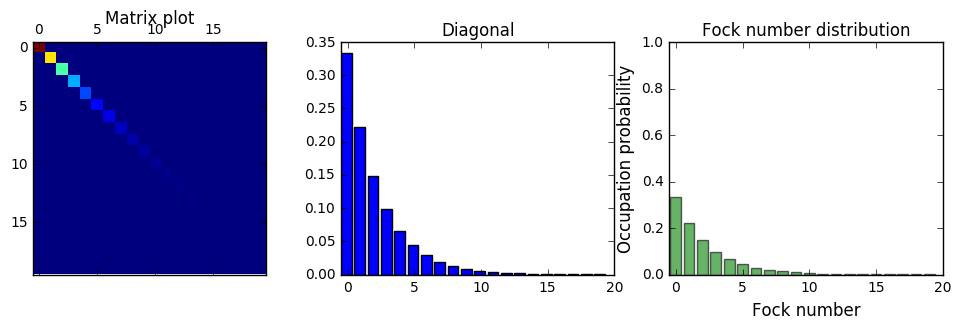

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(12,3))
axes[0].matshow(rho_thermal.data.toarray().real)
axes[0].set_title("Matrix plot")
axes[1].bar(np.arange(0, N)-.5, rho_thermal.diag())
axes[1].set_xlim([-.5, N])
axes[1].set_title("Diagonal")
plot_fock_distribution(rho_thermal, fig=fig, ax=axes[2])
axes[2].set_title("Fock number distribution")

**Exercise 3.2** Create and study the maximally mixed state of dimension $N$. Here are three possible ways to do it:
1. The Cheap Way: import the function `maximally_mixed_dm` from QuTiP.
2. The Way of the Boson: use the previous function `thermal_dm` and increase the average particle number until you converge to the maximally mixed state.
3. The Church of Nonlocality Way: trace out half of a maximally entangled state. For qubits, you could create a Bell pair with `(tensor(basis(2, 0), basis(2, 0)) + tensor(basis(2, 1), basis(2, 1))).unit()` and then trace out either party. If you generalize this to $N$ dimensions, you get the solution. Bonus points are awarded for simulating the Unruh effect.

4. Writing good code
====================

- PEP8

- Linting

- Profiling

5. Open science
===============

- Sharing code under open source licence.

- Notebook versus repository.

- Where.